In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eig
import os
import sys
import skimage.metrics as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def training_blocks(noisy_img, k):
  noisy_pad = np.pad(noisy_img, ((k//2,k//2), (k//2,k//2)), 'constant', constant_values=1)

  h, w = noisy_pad.shape
  h_blocks = h+1-k
  w_blocks = w+1-k
  blocks = np.zeros((k*k, (h_blocks*w_blocks)))

  x=0
  for i in range(k):
    for j in range(k):
      block = noisy_pad[i:h+1-k+i, j:w+1-k+j].reshape(-1)
      blocks[x,:] = block
      x+=1

  indx = np.array(range(h_blocks*w_blocks))
  indx = indx.reshape(h_blocks, w_blocks)

  return blocks, indx, h, w, h_blocks, w_blocks

def LPG(blocks, indx, i, j, h, w, h_blocks, w_blocks, c, nstd_dev, l, k, t):
  i = i + k//2
  j = j + k//2
  rmin = max(i-l//2, 0)
  rmax = min(i+l//2-k+1, h-k)
  cmin = max(j-l//2, 0)
  cmax = min(j+l//2-k+1, w-k)
  id = indx[rmin:rmax, cmin:cmax].reshape(-1)
  tblocks = blocks[:,id]
  offset = (i-k//2)*(h_blocks) + (j-k//2)
  a = blocks[:,offset].reshape(-1,1)
  dist = np.mean((tblocks- a)**2, axis=0)
  id = np.argsort(dist)
  dist = dist[id]
  tblocks = tblocks[:,id]

  th = t + 2*nstd_dev**2
  b = 0
  no_samples = c*(k**2)
  while b < tblocks.shape[1] and (dist[b] < th  or b < no_samples):
    b += 1

  return tblocks[:,:b]

def PCA(tblocks, nstd_dev):
  p,q = tblocks.shape
  mu = np.mean(tblocks, axis = 1, keepdims = True)
  cov = ((tblocks - mu)@((tblocks - mu).T))/q
  e_val, e_vec = eig(cov)
  PCA_mat = e_vec.T
  Y_cent = PCA_mat @ (tblocks - mu)
  cov_Yv_cent_diag = np.mean(Y_cent**2, axis=1, keepdims=True)
  cov_Y_cent_diag = np.maximum(0, cov_Yv_cent_diag - nstd_dev**2)
  w = [cov_Y_cent_diag[i,0] / cov_Yv_cent_diag[i,0] if cov_Y_cent_diag[i,0] != 0 else 0 for i in range(p)]
  w = np.array(w).reshape(-1,1)
  Yb = Y_cent * w
  Xb = PCA_mat.T@Yb
  X = Xb + mu
  x0 = X[p//2, 0]
  return x0

def update_noise(noisyI, firststageI, nstd_dev):
  I2 = noisyI - firststageI
  residual = 0.35*(np.sqrt(np.abs((nstd_dev**2)-np.mean(I2**2))))
  return residual

def lpg_pca(noisyI, nstd_dev):
  l = 41
  k = 5
  c = 8
  t = 25
  blocks, indx, h, w, h_blocks, w_blocks = training_blocks(noisyI, k)
  firststgI = noisyI.copy()
  for i in range(0, noisyI.shape[0]):
    for j in range(0, noisyI.shape[1]):
      tblocks = LPG(blocks, indx, i, j, h, w, h_blocks, w_blocks, c, nstd_dev, l, k, t)
      x0 = PCA(tblocks, nstd_dev)
      firststgI[i,j] = x0

  residual = update_noise(noisyI,firststgI, nstd_dev)

  blocks, indx, h, w, h_blocks, w_blocks = training_blocks(firststgI, k)
  scndstgI = firststgI.copy()
  for i in range(0, firststgI.shape[0]):
    for j in range(0, firststgI.shape[1]):
      tblocks = LPG(blocks, indx, i, j, h, w, h_blocks, w_blocks, c, nstd_dev, l, k, t)
      x0 = PCA(tblocks, nstd_dev)
      scndstgI[i,j] = x0

  return scndstgI

In [4]:
def awgn(image, sigma):
  noise = np.random.normal(0, sigma, image.shape)
  noisy_image = image.astype(np.float32) + noise
  noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
  return noisy_image

**AWGN for sigma = [15,25, 50]**

Sigma = 15, PSNR = 27.99476005101949, SSIM = 0.8229803782430691
Sigma = 25, PSNR = 26.304341889079986, SSIM = 0.772807997668547
Sigma = 50, PSNR = 22.123228815493196, SSIM = 0.6634614029257311


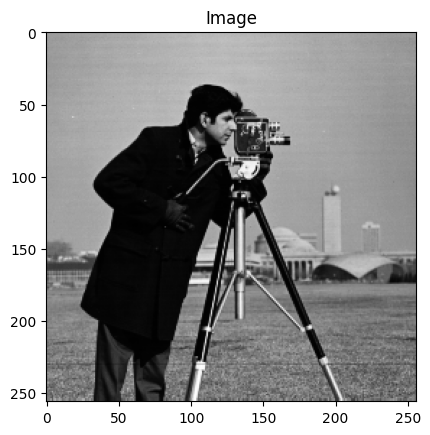

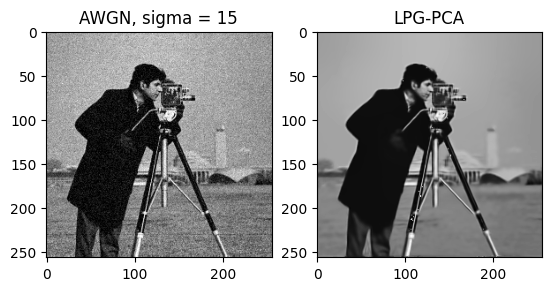

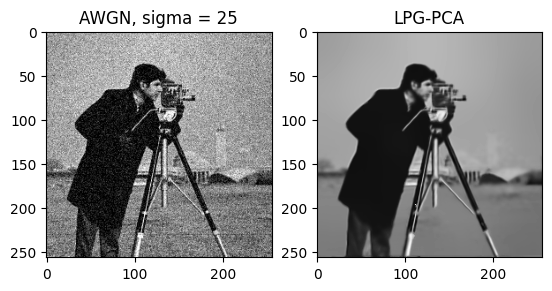

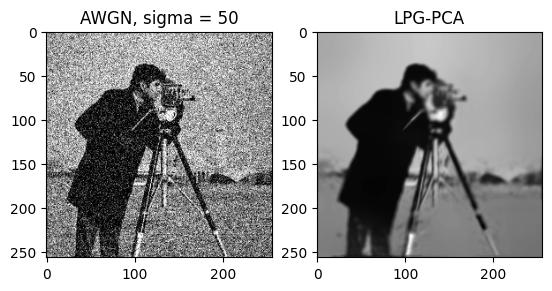

In [ ]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15,25, 50]:
  plt.figure()
  plt.tight_layout()
  plt.subplot(1,2,1)
  distorted = awgn(aerial,sigma)
  plt.imshow(distorted, cmap='gray')
  plt.title(f'AWGN, sigma = {sigma}')
  newI = lpg_pca(distorted, sigma)
  psnr = sm.peak_signal_noise_ratio(aerial, newI)
  ssim = sm.structural_similarity(aerial, newI)
  plt.subplot(1,2,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  print(f'Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

Sigma = 15, PSNR = 28.855012643842603, SSIM = 0.8605233206696715
Sigma = 25, PSNR = 25.977579493121535, SSIM = 0.786529492196986
Sigma = 50, PSNR = 21.750859436301866, SSIM = 0.6233381938970761


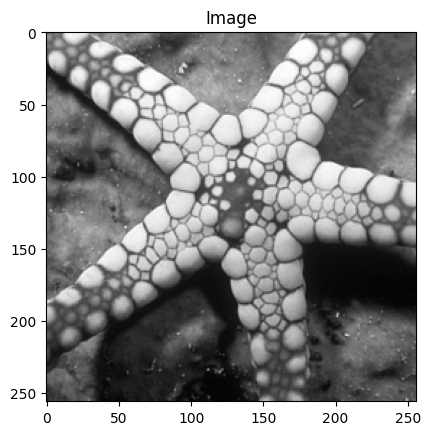

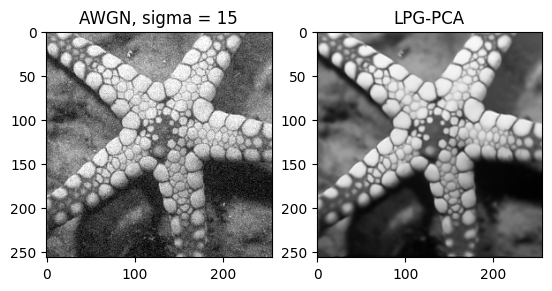

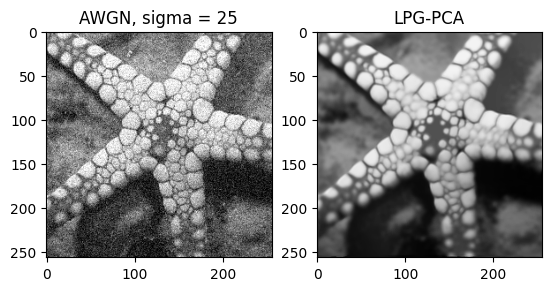

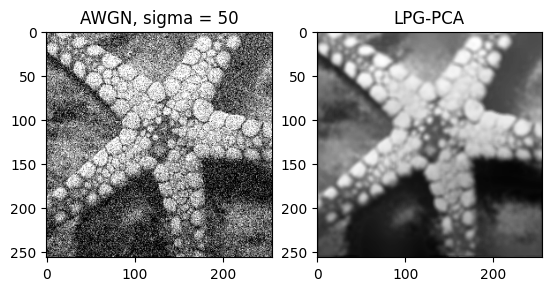

In [5]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/04.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15,25, 50]:
  plt.figure()
  plt.tight_layout()
  plt.subplot(1,2,1)
  distorted = awgn(aerial,sigma)
  plt.imshow(distorted, cmap='gray')
  plt.title(f'AWGN, sigma = {sigma}')
  newI = lpg_pca(distorted, sigma)
  psnr = sm.peak_signal_noise_ratio(aerial, newI)
  ssim = sm.structural_similarity(aerial, newI)
  plt.subplot(1,2,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  print(f'Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

**Denoising Spacially Noised Image**

(256, 256)


<ipython-input-3-43faa5da88e5>:88: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


Sigma = 15, PSNR = 17.666430375921912, SSIM = 0.6138960446477925


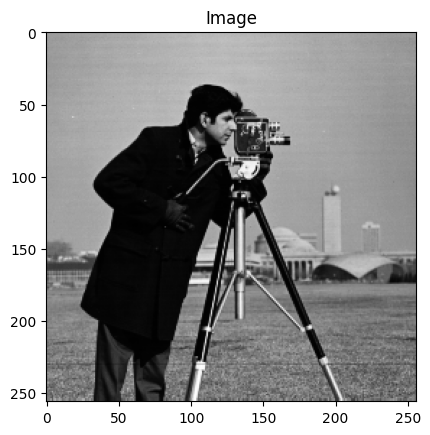

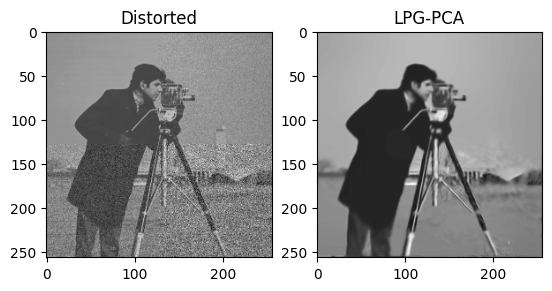

In [6]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
img = img.convert("L")
aerial = np.asarray(img)
print(aerial.shape)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15]:
  plt.figure()
  plt.tight_layout()
  img = Image.open(f'/content/drive/MyDrive/IVP/Set12_noisy/01.png')
  img = img.convert("L")
  aerial2 = np.asarray(img)
  plt.subplot(1,2,1)
  plt.imshow(aerial2, cmap='gray')
  plt.title(f'Distorted')
  newI = lpg_pca(aerial2, sigma)
  psnr = sm.peak_signal_noise_ratio(aerial, newI)
  ssim = sm.structural_similarity(aerial, newI)
  plt.subplot(1,2,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  print(f'Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

(256, 256)
Sigma = 15, PSNR = 16.653802279369252, SSIM = 0.5756515733424288


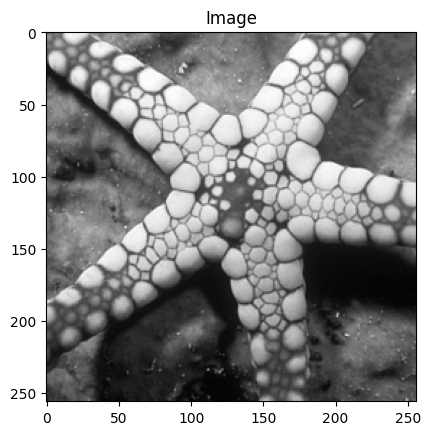

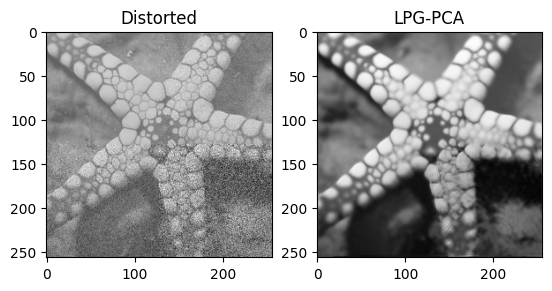

In [5]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/04.png')
img = img.convert("L")
aerial = np.asarray(img)
print(aerial.shape)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15]:
  plt.figure()
  plt.tight_layout()
  img = Image.open(f'/content/drive/MyDrive/IVP/Set12_noisy/04.png')
  img = img.convert("L")
  aerial2 = np.asarray(img)
  plt.subplot(1,2,1)
  plt.imshow(aerial2, cmap='gray')
  plt.title(f'Distorted')
  newI = lpg_pca(aerial2, sigma)
  psnr = sm.peak_signal_noise_ratio(aerial, newI)
  ssim = sm.structural_similarity(aerial, newI)
  plt.subplot(1,2,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  print(f'Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

**Average for Set12 Images with AWGN (level = 15)**

In [6]:
#Time shown is not using Colab T4, it was calculted using T4 previously.
#Time on T4 = 2hours
import time
for sigma in [15]:
  avg_psnr = 0
  avg_ssim = 0
  print(f"-------Sigma = {sigma}-----\n")
  start = time.time()
  for i in range(1,13,1):
    if(i<10):
      img = Image.open('/content/drive/MyDrive/IVP/Set12/0'+f'{i}.png')
    else:
      img = Image.open(f'/content/drive/MyDrive/IVP/Set12/{i}.png')
    img = img.convert("L")
    aerial = np.asarray(img)
    distorted = awgn(aerial,sigma)
    newI = lpg_pca(distorted, sigma)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    avg_psnr += psnr
    avg_ssim += ssim
    print(f'Image = {i}, PSNR = {psnr}, SSIM = {ssim}')
  end = time.time()
  PSNR = avg_psnr/12
  SSIM = avg_ssim/12
  t = end - start
  print(f"Average psnr = {PSNR}, Average ssim = {SSIM}, Time = {t}")

-------Sigma = 15-----

Image = 1, PSNR = 28.130122426251837, SSIM = 0.8228460158345257
Image = 2, PSNR = 31.22533607358873, SSIM = 0.8394667326048703
Image = 3, PSNR = 28.36283333988481, SSIM = 0.8707801001259982
Image = 4, PSNR = 28.881089673771598, SSIM = 0.8612630849670747
Image = 5, PSNR = 28.807646774225187, SSIM = 0.9078635482951083
Image = 6, PSNR = 26.616927958453388, SSIM = 0.8434919869786092
Image = 7, PSNR = 25.7591889849164, SSIM = 0.8347470938592725
Image = 8, PSNR = 31.841068721703696, SSIM = 0.8588879080127807
Image = 9, PSNR = 30.344612614304882, SSIM = 0.8822420715883149
Image = 10, PSNR = 29.364729691165966, SSIM = 0.7776684588655619
Image = 11, PSNR = 29.27894687490122, SSIM = 0.7893317553045106
Image = 12, PSNR = 28.898847649187914, SSIM = 0.7846484947093622
Average psnr = 28.95927923186297, Average ssim = 0.8394364375954991, Time = 12241.17202949524


**Average for Set12 Images with Spacially varied noise**

In [21]:
#Time shown is not using Colab T4, it was calculted using T4 previously.
#Time on T4 = 3 hours
import time
for sigma in [15]:
  avg_psnr = 0
  avg_ssim = 0
  print(f"-------Sigma = {sigma}-----\n")
  start = time.time()
  for i in range(1,13,1):
    if(i<10):
      img = Image.open('/content/drive/MyDrive/IVP/Set12/0'+f'{i}.png')
      img2 = Image.open('/content/drive/MyDrive/IVP/Set12_noisy/0'+f'{i}.png')
    else:
      img = Image.open(f'/content/drive/MyDrive/IVP/Set12/{i}.png')
      img = Image.open(f'/content/drive/MyDrive/IVP/Set12_noisy/{i}.png')
    img = img.convert("L")
    aerial2 = np.asarray(img)
    newI = lpg_pca(aerial2, sigma)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    avg_psnr += psnr
    avg_ssim += ssim
    print(f'Image = {i}, PSNR = {psnr}, SSIM = {ssim}')
  end = time.time()
  PSNR = avg_psnr/12
  SSIM = avg_ssim/12
  t = end - start
  print(f"Average psnr = {PSNR}, Average ssim = {SSIM}, Time = {t}")

-------Sigma = 15-----



<ipython-input-13-43faa5da88e5>:88: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


Image = 1, PSNR = 24.286105296214128, SSIM = 0.5431115148527312
Image = 2, PSNR = 24.658714617676672, SSIM = 0.5183750130447877
Image = 3, PSNR = 24.28438444137157, SSIM = 0.540115916140711
Image = 4, PSNR = 24.10380570697278, SSIM = 0.5536981870586668
Image = 5, PSNR = 24.574513884591653, SSIM = 0.6083364557442026
Image = 6, PSNR = 23.996291533001347, SSIM = 0.5432016716963489
Image = 7, PSNR = 25.357832606956524, SSIM = 0.5189699256048808
Image = 8, PSNR = 24.91776877664442, SSIM = 0.5162795249852546
Image = 9, PSNR = 25.366876177310953, SSIM = 0.5546930388698582
Image = 10, PSNR = 25.094933412078003, SSIM = 0.5078001994439054
Image = 11, PSNR = 24.54478179757473, SSIM = 0.4735623495390254
Image = 12, PSNR = 25.464633279871958, SSIM = 0.4971221400748149
Average psnr = 24.72088679418873, Average ssim = 0.5312721614212657, Time = 15693.77549290657


**Average for all sigmas AWGN Set12**

In [ ]:
for sigma in [15,25, 50]:
  avg_psnr = 0
  avg_ssim = 0
  print(f"-------Sigma = {sigma}-----\n")
  for i in range(1,13,1):
    if(i<10):
      img = Image.open('/content/drive/MyDrive/IVP/Set12/0'+f'{i}.png')
    else:
      img = Image.open(f'/content/drive/MyDrive/IVP/Set12/{i}.png')
    aerial = np.asarray(img)
    aerial = aerial[40:104, 40:104]
    distorted = awgn(aerial,sigma)
    newI = lpg_pca(distorted, sigma)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    avg_psnr += psnr
    avg_ssim += ssim
  PSNR = avg_psnr/12
  SSIM = avg_ssim/12
  print(f"Average psnr = {PSNR}, Average ssim = {SSIM}")

-------Sigma = 15-----

Average psnr = 28.526876374116004, Average ssim = 0.8515623561725473
-------Sigma = 25-----

Average psnr = 26.549693052804496, Average ssim = 0.7980108700087675
-------Sigma = 50-----

Average psnr = 22.79072937926108, Average ssim = 0.6616529853796542


**Average for all sigmas AWGN BSD68**

In [ ]:
for sigma in [15,25, 50]:
  avg_psnr = 0
  avg_ssim = 0
  print(f"-------Sigma = {sigma}-----\n")
  for i in range(1,68,1):
    if(i<10):
      img = Image.open('/content/drive/MyDrive/IVP/BSD68/test00'+f'{i}.png')
    else:
      img = Image.open('/content/drive/MyDrive/IVP/BSD68/test0'+f'{i}.png')
    aerial = np.asarray(img)
    aerial = aerial[1:64, 1:64]
    distorted = awgn(aerial,sigma)
    newI = lpg_pca(distorted, sigma)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    avg_psnr += psnr
    avg_ssim += ssim
    print(f'Image = {i}, PSNR = {psnr}, SSIM = {ssim}')
  PSNR = avg_psnr/68
  SSIM = avg_ssim/68
  print(f"Average psnr = {PSNR}, Average ssim = {SSIM}")

-------Sigma = 15-----

Image = 1, PSNR = 21.86001314620256, SSIM = 0.7976410196913792


<ipython-input-43-dae89973a339>:88: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


Image = 2, PSNR = 30.43532236640464, SSIM = 0.9885111834582692
Image = 3, PSNR = 39.37836766358917, SSIM = 0.9803487564693176
Image = 4, PSNR = 33.46234027838831, SSIM = 0.9009536284729235
Image = 5, PSNR = 25.741206316153477, SSIM = 0.8252690720400833
Image = 6, PSNR = 34.52314597111632, SSIM = 0.949174751703893
Image = 7, PSNR = 32.45550472721388, SSIM = 0.8706438288942965
Image = 8, PSNR = 28.165199370508734, SSIM = 0.6806374694981157
Image = 9, PSNR = 27.670993794152817, SSIM = 0.7897934790598659
Image = 10, PSNR = 35.14249829199964, SSIM = 0.9345428754067316
Image = 11, PSNR = 30.30532628672795, SSIM = 0.9210747252055699
Image = 12, PSNR = 33.886119257211554, SSIM = 0.7876170494364888
Image = 13, PSNR = 28.04996494002584, SSIM = 0.6806336127654348
Image = 14, PSNR = 39.9342701747009, SSIM = 0.986996320764152
Image = 15, PSNR = 31.01000194687433, SSIM = 0.9136342657876748
Image = 16, PSNR = 25.113566392709288, SSIM = 0.9149618674412521
Image = 17, PSNR = 31.288970070660852, SSIM = 

# **Analysing Hyperparameters and their impact**

In [10]:
def training_blocks(noisy_img, k):
  noisy_pad = np.pad(noisy_img, ((k//2,k//2), (k//2,k//2)), 'constant', constant_values=1)

  h, w = noisy_pad.shape
  h_blocks = h+1-k
  w_blocks = w+1-k
  blocks = np.zeros((k*k, (h_blocks*w_blocks)))

  x=0
  for i in range(k):
    for j in range(k):
      block = noisy_pad[i:h+1-k+i, j:w+1-k+j].reshape(-1)
      blocks[x,:] = block
      x+=1

  indx = np.array(range(h_blocks*w_blocks))
  indx = indx.reshape(h_blocks, w_blocks)

  return blocks, indx, h, w, h_blocks, w_blocks

def LPG(blocks, indx, i, j, h, w, h_blocks, w_blocks, c, nstd_dev, l, k, t):
  i = i + k//2
  j = j + k//2
  rmin = max(i-l//2, 0)
  rmax = min(i+l//2-k+1, h-k)
  cmin = max(j-l//2, 0)
  cmax = min(j+l//2-k+1, w-k)
  id = indx[rmin:rmax, cmin:cmax].reshape(-1)
  tblocks = blocks[:,id]
  offset = (i-k//2)*(h_blocks) + (j-k//2)
  a = blocks[:,offset].reshape(-1,1)
  dist = np.mean((tblocks- a)**2, axis=0)
  id = np.argsort(dist)
  dist = dist[id]
  tblocks = tblocks[:,id]

  th = t + 2*nstd_dev**2
  b = 0
  no_samples = c*(k**2)
  while b < tblocks.shape[1] and (dist[b] < th  or b < no_samples):
    b += 1

  return tblocks[:,:b]

def PCA(tblocks, nstd_dev):
  p,q = tblocks.shape
  mu = np.mean(tblocks, axis = 1, keepdims = True)
  cov = ((tblocks - mu)@((tblocks - mu).T))/q
  e_val, e_vec = eig(cov)
  PCA_mat = e_vec.T
  Y_cent = PCA_mat @ (tblocks - mu)
  cov_Yv_cent_diag = np.mean(Y_cent**2, axis=1, keepdims=True)
  cov_Y_cent_diag = np.maximum(0, cov_Yv_cent_diag - nstd_dev**2)
  w = [cov_Y_cent_diag[i,0] / cov_Yv_cent_diag[i,0] if cov_Y_cent_diag[i,0] != 0 else 0 for i in range(p)]
  w = np.array(w).reshape(-1,1)
  Yb = Y_cent * w
  Xb = PCA_mat.T@Yb
  X = Xb + mu
  x0 = X[p//2, 0]
  return x0

def update_noise(noisyI, firststageI, nstd_dev):
  I2 = noisyI - firststageI
  residual = 0.35*(np.sqrt(np.abs((nstd_dev**2)-np.mean(I2**2))))
  return residual

def lpg_pca(noisyI, nstd_dev, l, k, c, t):
  blocks, indx, h, w, h_blocks, w_blocks = training_blocks(noisyI, k)
  firststgI = noisyI.copy()
  for i in range(0, noisyI.shape[0]):
    for j in range(0, noisyI.shape[1]):
      tblocks = LPG(blocks, indx, i, j, h, w, h_blocks, w_blocks, c, nstd_dev, l, k, t)
      x0 = PCA(tblocks, nstd_dev)
      firststgI[i,j] = x0

  residual = update_noise(noisyI,firststgI, nstd_dev)

  blocks, indx, h, w, h_blocks, w_blocks = training_blocks(firststgI, k)
  scndstgI = firststgI.copy()
  for i in range(0, firststgI.shape[0]):
    for j in range(0, firststgI.shape[1]):
      tblocks = LPG(blocks, indx, i, j, h, w, h_blocks, w_blocks, c, nstd_dev, l, k, t)
      x0 = PCA(tblocks, nstd_dev)
      scndstgI[i,j] = x0

  return scndstgI

<ipython-input-8-d4d0d4baca4f>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  firststgI[i,j] = x0
<ipython-input-8-d4d0d4baca4f>:84: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


l = 11, Sigma = 15, PSNR = 25.210343018985846, SSIM = 0.8294101911367031
l = 41, Sigma = 15, PSNR = 28.380685233111315, SSIM = 0.8250563391348512
l = 81, Sigma = 15, PSNR = 28.284418824575546, SSIM = 0.8214963990548836


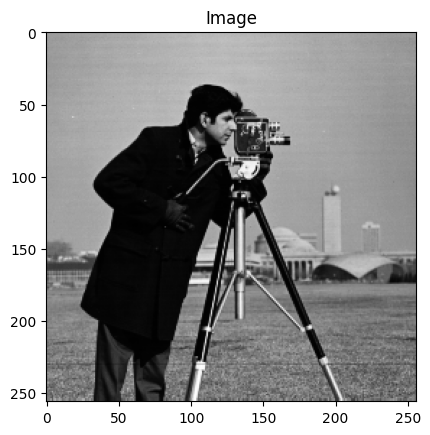

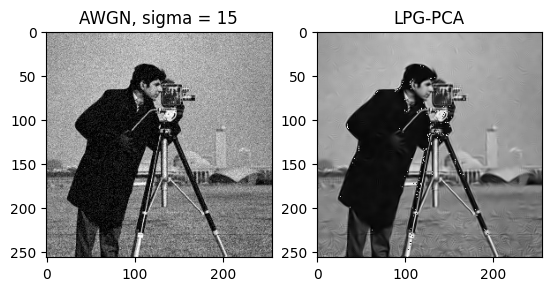

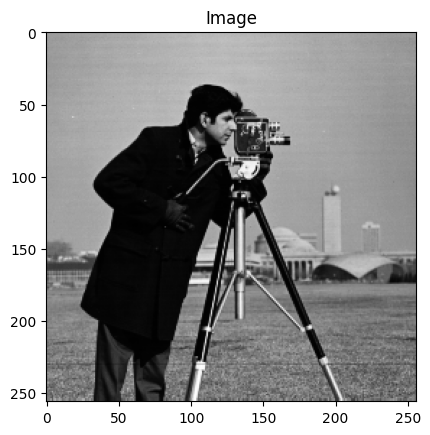

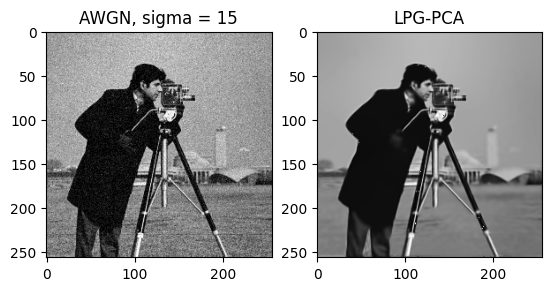

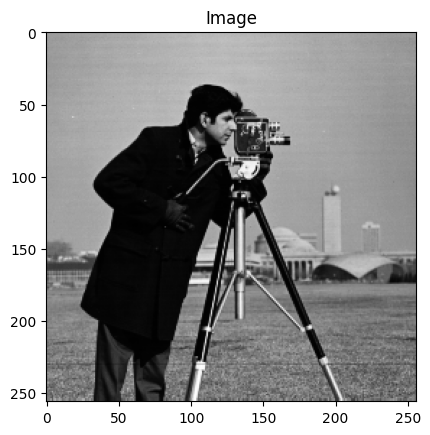

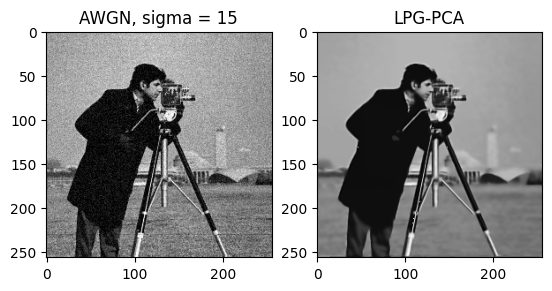

In [10]:
ls = [11,41,81]
k = 5
c = 8
t = 25

for l in ls:
  img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
  aerial = np.asarray(img)
  plt.figure()
  plt.imshow(aerial, cmap='gray')
  plt.title('Image')

  for sigma in [15]:
    plt.figure()
    plt.tight_layout()
    plt.subplot(1,2,1)
    distorted = awgn(aerial,sigma)
    plt.imshow(distorted, cmap='gray')
    plt.title(f'AWGN, sigma = {sigma}')
    newI = lpg_pca(distorted, sigma, l, k, c, t)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    plt.subplot(1,2,2)
    plt.imshow(newI, cmap='gray')
    plt.title(f'LPG-PCA')
    print(f'l = {l}, Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

L = 41 gives the best PSNR and almost same SSIM as l= 11. The performance reduced on increasing l to 81. When l is smaller, there's a chance that the window used to search for training samples will be too narrow to yield enough relevant results. It is possible that inaccurate non-local information will be introduced for fine-grain structures with bigger values of l.

k = 3, Sigma = 15, PSNR = 28.701682169224448, SSIM = 0.8312432681143447
k = 5, Sigma = 15, PSNR = 27.94414419459799, SSIM = 0.8227331647831388
k = 7, Sigma = 15, PSNR = 27.050292909938438, SSIM = 0.8241212181861453


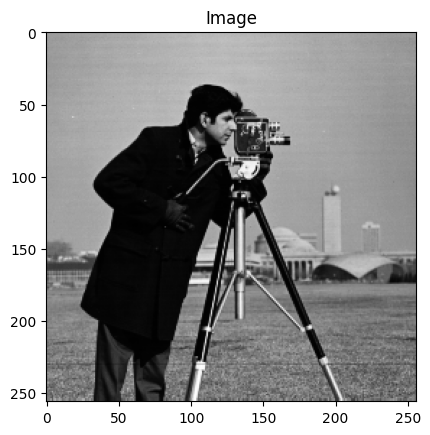

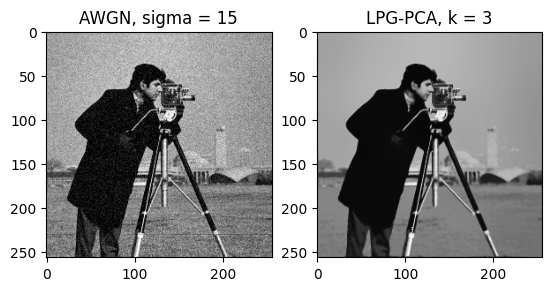

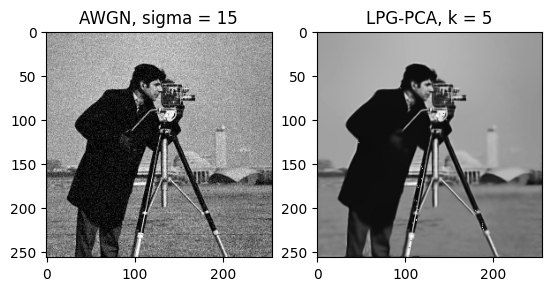

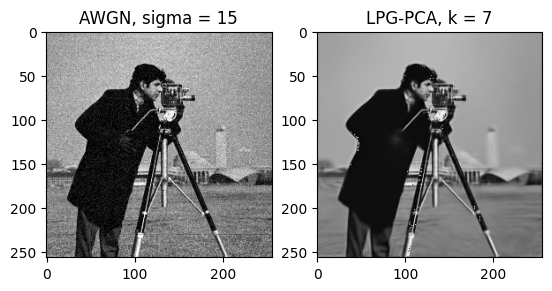

In [15]:
l = 41
ks = [3,5,7]
c = 8
t = 25

img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for k in ks:
  for sigma in [15]:
    plt.figure()
    plt.tight_layout()
    plt.subplot(1,2,1)
    distorted = awgn(aerial,sigma)
    plt.imshow(distorted, cmap='gray')
    plt.title(f'AWGN, sigma = {sigma}')
    newI = lpg_pca(distorted, sigma, l, k, c, t)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    plt.subplot(1,2,2)
    plt.imshow(newI, cmap='gray')
    plt.title(f'LPG-PCA, k = {k}')
    print(f'k = {k}, Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

k = 3, Sigma = 15, PSNR = 28.788163769703342, SSIM = 0.8762777060818397
k = 5, Sigma = 15, PSNR = 28.817893874391043, SSIM = 0.8608971576098867
k = 7, Sigma = 15, PSNR = 28.78930496289128, SSIM = 0.8543683911905727


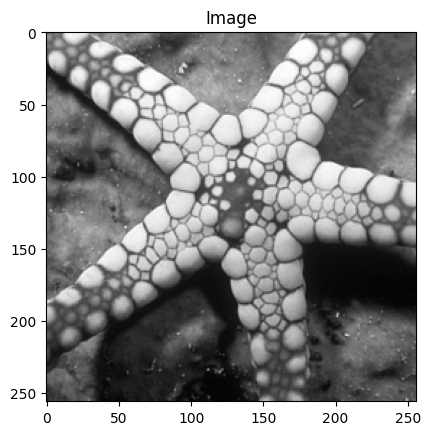

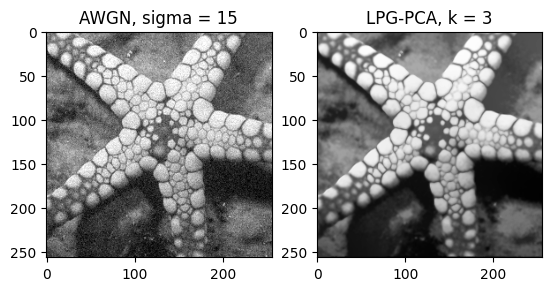

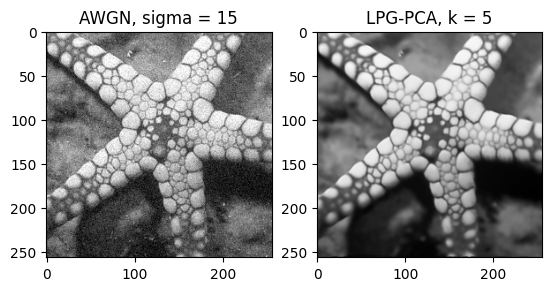

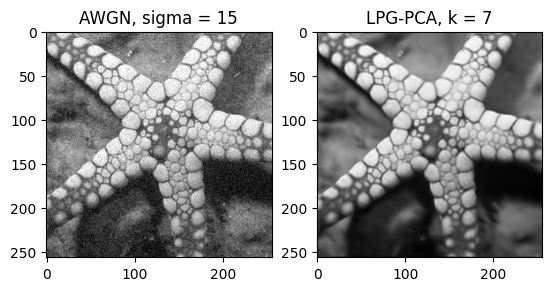

In [31]:
l = 41
ks = [3,5,7]
c = 8
t = 25

img = Image.open(f'/content/drive/MyDrive/IVP/Set12/04.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for k in ks:
  for sigma in [15]:
    plt.figure()
    plt.tight_layout()
    plt.subplot(1,2,1)
    distorted = awgn(aerial,sigma)
    plt.imshow(distorted, cmap='gray')
    plt.title(f'AWGN, sigma = {sigma}')
    newI = lpg_pca(distorted, sigma, l, k, c, t)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    plt.subplot(1,2,2)
    plt.imshow(newI, cmap='gray')
    plt.title(f'LPG-PCA, k = {k}')
    print(f'k = {k}, Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

Finding training samples that are sufficiently near to the target block may become too difficult for values of k as they increase. Hence, the performance reduces.

<ipython-input-8-d4d0d4baca4f>:84: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


k = 4, Sigma = 15, PSNR = 28.871233980322856, SSIM = 0.8344268033348871
k = 8, Sigma = 15, PSNR = 28.70280085955806, SSIM = 0.8307920014315936
k = 12, Sigma = 15, PSNR = 28.43733011524108, SSIM = 0.8299762126423261


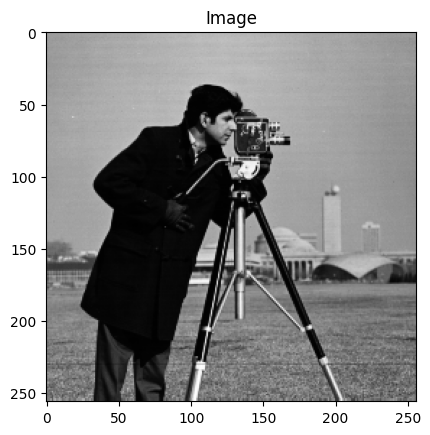

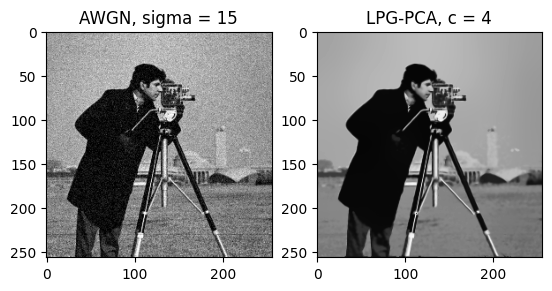

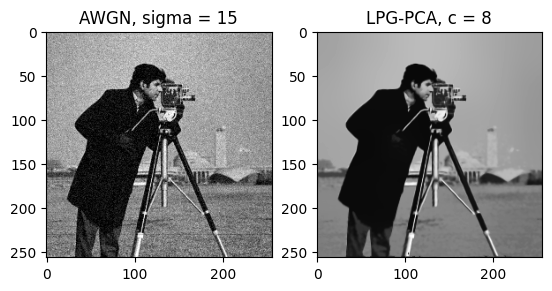

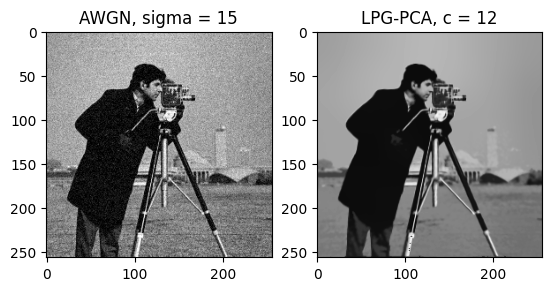

In [16]:
l = 41
k = 3
cs = [4, 8, 12]
t = 25

img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for c in cs:
  for sigma in [15]:
    plt.figure()
    plt.tight_layout()
    plt.subplot(1,2,1)
    distorted = awgn(aerial,sigma)
    plt.imshow(distorted, cmap='gray')
    plt.title(f'AWGN, sigma = {sigma}')
    newI = lpg_pca(distorted, sigma, l, k, c, t)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    plt.subplot(1,2,2)
    plt.imshow(newI, cmap='gray')
    plt.title(f'LPG-PCA, c = {c}')
    print(f'k = {c}, Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

<ipython-input-8-d4d0d4baca4f>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  firststgI[i,j] = x0


k = 4, Sigma = 15, PSNR = 29.001525755083144, SSIM = 0.8809263907024065
k = 8, Sigma = 15, PSNR = 28.76739103040016, SSIM = 0.873298610389409
k = 12, Sigma = 15, PSNR = 28.63480878486974, SSIM = 0.8723382385400994


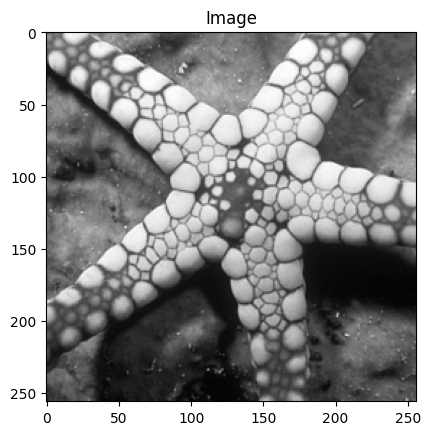

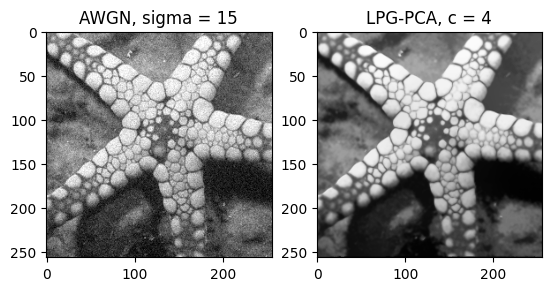

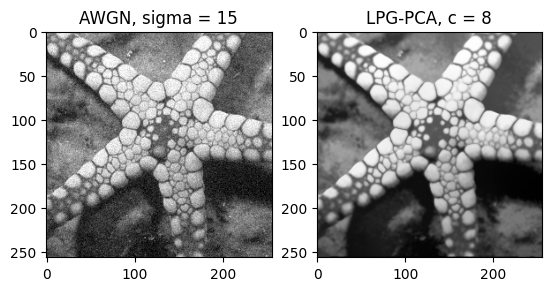

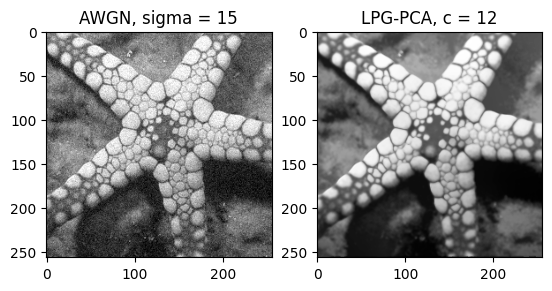

In [29]:
l = 41
k = 3
cs = [4, 8, 12]
t = 25

img = Image.open(f'/content/drive/MyDrive/IVP/Set12/04.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for c in cs:
  for sigma in [15]:
    plt.figure()
    plt.tight_layout()
    plt.subplot(1,2,1)
    distorted = awgn(aerial,sigma)
    plt.imshow(distorted, cmap='gray')
    plt.title(f'AWGN, sigma = {sigma}')
    newI = lpg_pca(distorted, sigma, l, k, c, t)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    plt.subplot(1,2,2)
    plt.imshow(newI, cmap='gray')
    plt.title(f'LPG-PCA, c = {c}')
    print(f'k = {c}, Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

c = 4 in both cases seems to give a better performance for Image size = 256. Higher value of c compels the LPG algorithm to choose samples that may be too far away from the target block.

<ipython-input-8-d4d0d4baca4f>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  firststgI[i,j] = x0


t = 5, Sigma = 15, PSNR = 29.079969731341286, SSIM = 0.8382345947729067


<ipython-input-8-d4d0d4baca4f>:84: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


t = 25, Sigma = 15, PSNR = 28.87405143075217, SSIM = 0.8357146083523491
t = 45, Sigma = 15, PSNR = 28.961567654249407, SSIM = 0.8351420710911595


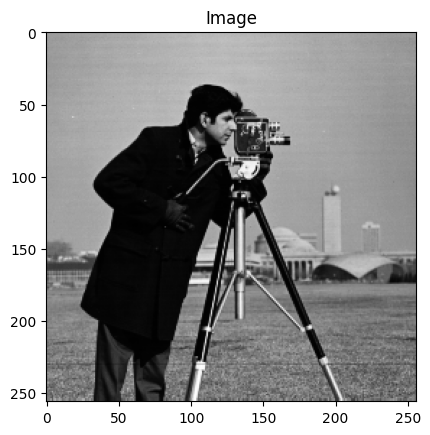

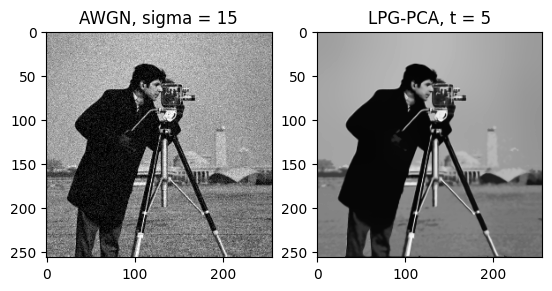

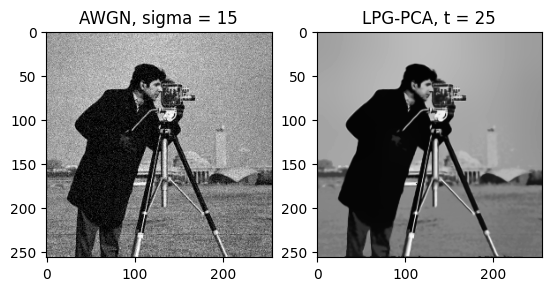

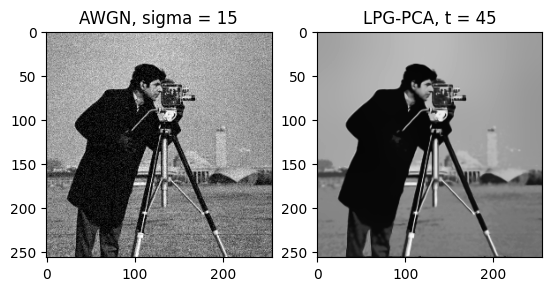

In [17]:
l = 41
k = 3
c = 4
ts = [5, 25, 45]

img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for t in ts:
  for sigma in [15]:
    plt.figure()
    plt.tight_layout()
    plt.subplot(1,2,1)
    distorted = awgn(aerial,sigma)
    plt.imshow(distorted, cmap='gray')
    plt.title(f'AWGN, sigma = {sigma}')
    newI = lpg_pca(distorted, sigma, l, k, c, t)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    plt.subplot(1,2,2)
    plt.imshow(newI, cmap='gray')
    plt.title(f'LPG-PCA, t = {t}')
    print(f't = {t}, Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

<ipython-input-8-d4d0d4baca4f>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  firststgI[i,j] = x0
<ipython-input-8-d4d0d4baca4f>:84: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


t = 5, Sigma = 15, PSNR = 28.97836102333415, SSIM = 0.8801537585928935
t = 25, Sigma = 15, PSNR = 29.067271162772123, SSIM = 0.8811859381751057
t = 45, Sigma = 15, PSNR = 29.044469595687833, SSIM = 0.8807146346906735


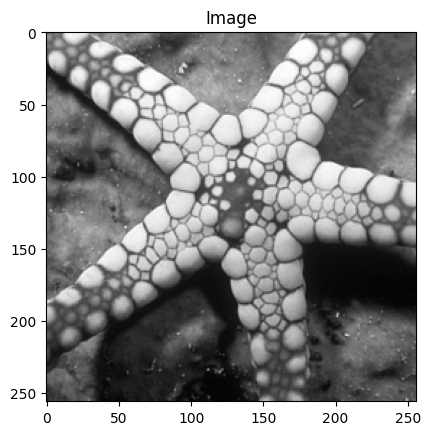

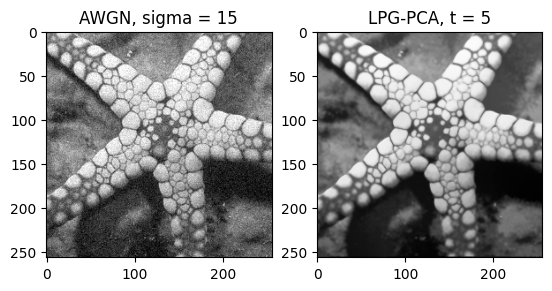

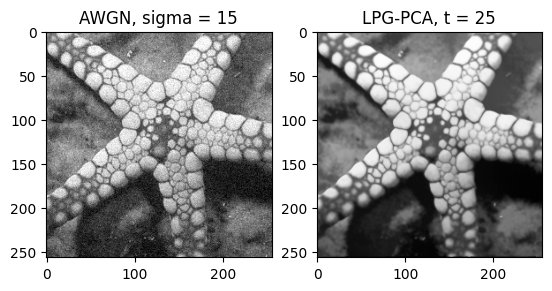

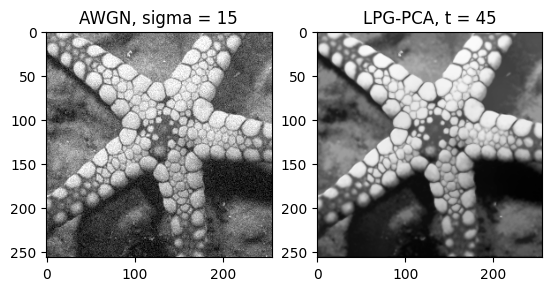

In [28]:
l = 41
k = 3
c = 4
ts = [5, 25, 45]

img = Image.open(f'/content/drive/MyDrive/IVP/Set12/04.png')
aerial = np.asarray(img)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for t in ts:
  for sigma in [15]:
    plt.figure()
    plt.tight_layout()
    plt.subplot(1,2,1)
    distorted = awgn(aerial,sigma)
    plt.imshow(distorted, cmap='gray')
    plt.title(f'AWGN, sigma = {sigma}')
    newI = lpg_pca(distorted, sigma, l, k, c, t)
    psnr = sm.peak_signal_noise_ratio(aerial, newI)
    ssim = sm.structural_similarity(aerial, newI)
    plt.subplot(1,2,2)
    plt.imshow(newI, cmap='gray')
    plt.title(f'LPG-PCA, t = {t}')
    print(f't = {t}, Sigma = {sigma}, PSNR = {psnr}, SSIM = {ssim}')

The threhold does not affect the PSNR and the SSIM significantly. This hyperparameter has a negligible effect because the training samples are approved based on a minimum number of samples in addition to the threshold that is dependent on c*K*K. The minimum number of samples is more significant than the threshold from the above results as t = 25 gives better results for starfish image whereas t=5 gives better results for the cameraman image.

**Analysis Using SSIM MAP for Spacially-noised Images**

In [8]:
import numpy as np

def MSE(img1, img2):
    img1 = np.array(img1, np.int32)
    img2 = np.array(img2, np.int32)
    mse_loss = np.mean(np.square(img1 - img2))
    psnr = 10*np.log10((255**2)/mse_loss)

    return mse_loss, psnr

def pad(img, window_size):
    pad_size = window_size//2

    img_padded = np.copy(img)
    img_padded = np.append(img, np.zeros((img.shape[0], pad_size)), axis= 1)
    img_padded = np.append(np.zeros((img_padded.shape[0], pad_size)), img_padded, axis= 1)
    img_padded = np.append(img_padded, np.zeros((pad_size, img_padded.shape[1])), axis= 0)
    img_padded = np.append(np.zeros((pad_size, img_padded.shape[1])), img_padded, axis= 0)

    return img_padded

def correlate(patch, kernel):
    return np.sum(patch*kernel)

def SSIM(img1, img2):
    img1 = np.array(img1, np.int32)
    img2 = np.array(img2, np.int32)
    window_size = 11
    sigma = 1.2

    gauss = np.zeros((window_size, window_size))

    for i, row in enumerate(gauss):
        for j, _ in enumerate(row):
            i_ = i - window_size//2
            j_ = j - window_size//2
            gauss[i, j] = np.exp(-1*(i_**2 + j_**2)/(2*sigma**2))/(2*np.pi*sigma**2)

    gauss /= np.sum(gauss)

    img1_padded = pad(img1, window_size)
    img2_padded = pad(img2, window_size)

    ssim_map = np.zeros(img1.shape)
    c1 = (0.01*255)**2
    c2 = (0.03*255)**2
    c3 = c2/2

    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            i_ = i + window_size//2
            j_ = j + window_size//2

            patch_x = img1_padded[i_ - window_size//2:i_ + window_size//2 + 1, j_ - window_size//2:j_ + window_size//2 + 1]
            patch_y = img2_padded[i_ - window_size//2:i_ + window_size//2 + 1, j_ - window_size//2:j_ + window_size//2 + 1]

            mu_x = correlate(patch_x, gauss)
            mu_y = correlate(patch_y, gauss)

            sigma_x = np.sqrt(correlate(np.square(patch_x - np.mean(patch_x)), gauss))
            sigma_y = np.sqrt(correlate(np.square(patch_y - np.mean(patch_y)), gauss))

            sigma_xy = correlate((patch_x - np.mean(patch_x))*(patch_y - np.mean(patch_y)), gauss)

            l = (2*mu_x*mu_y + c1)/(mu_x**2 + mu_y**2 + c1)
            c = (2*sigma_x*sigma_y + c2)/(sigma_x**2 + sigma_y**2 + c2)
            s = (sigma_xy + c3)/(sigma_x*sigma_y + c3)

            ssim_map[i, j] = l*c*s

    mssim = np.mean(ssim_map)

    return ssim_map, mssim

(256, 256)


<ipython-input-8-d4d0d4baca4f>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  firststgI[i,j] = x0


SSIM = 0.5918503254233554


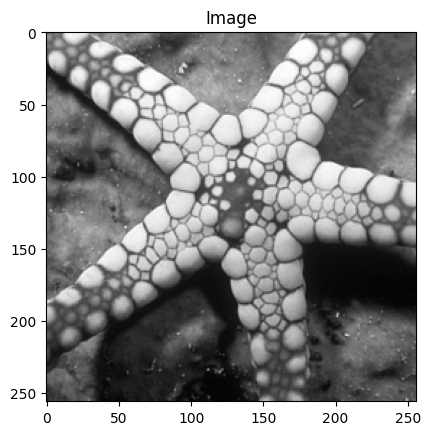

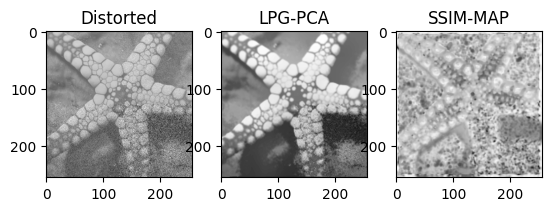

In [22]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/04.png')
img = img.convert("L")
aerial = np.asarray(img)
print(aerial.shape)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15]:
  plt.figure()
  plt.tight_layout()
  img = Image.open(f'/content/drive/MyDrive/IVP/Set12_noisy/04.png')
  img = img.convert("L")
  aerial2 = np.asarray(img)
  plt.subplot(1,3,1)
  plt.imshow(aerial2, cmap='gray')
  plt.title(f'Distorted')
  newI = lpg_pca(aerial2, sigma, 41, 3, 4, 5)
  ssim_map, ssim = SSIM(aerial, newI)
  plt.subplot(1,3,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  plt.subplot(1,3,3)
  plt.imshow(ssim_map, cmap='gray')
  plt.title(f'SSIM-MAP')
  print(f'SSIM = {ssim}')

(256, 256)
SSIM = 0.5922335578472644


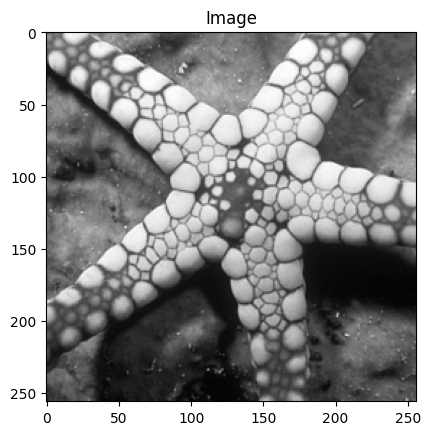

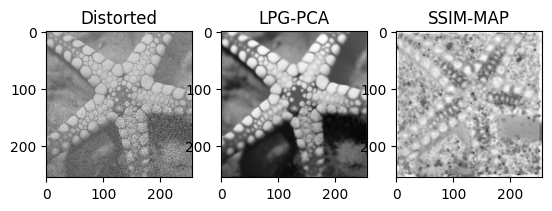

In [24]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/04.png')
img = img.convert("L")
aerial = np.asarray(img)
print(aerial.shape)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15]:
  plt.figure()
  plt.tight_layout()
  img = Image.open(f'/content/drive/MyDrive/IVP/Set12_noisy/04.png')
  img = img.convert("L")
  aerial2 = np.asarray(img)
  plt.subplot(1,3,1)
  plt.imshow(aerial2, cmap='gray')
  plt.title(f'Distorted')
  newI = lpg_pca(aerial2, sigma, 41, 5, 8, 25)
  ssim_map, ssim = SSIM(aerial, newI)
  plt.subplot(1,3,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  plt.subplot(1,3,3)
  plt.imshow(ssim_map, cmap='gray')
  plt.title(f'SSIM-MAP')
  print(f'SSIM = {ssim}')

(256, 256)


<ipython-input-8-d4d0d4baca4f>:84: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


SSIM = 0.6308347016347754


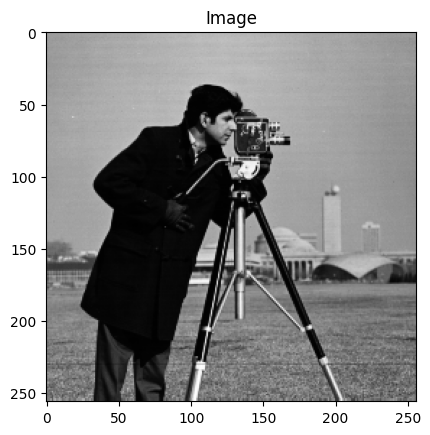

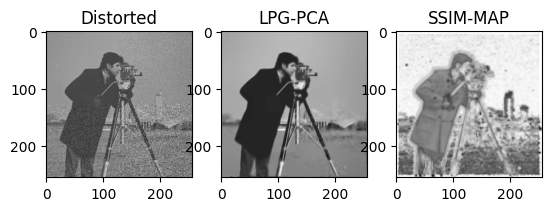

In [26]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
img = img.convert("L")
aerial = np.asarray(img)
print(aerial.shape)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15]:
  plt.figure()
  plt.tight_layout()
  img = Image.open(f'/content/drive/MyDrive/IVP/Set12_noisy/01.png')
  img = img.convert("L")
  aerial2 = np.asarray(img)
  plt.subplot(1,3,1)
  plt.imshow(aerial2, cmap='gray')
  plt.title(f'Distorted')
  newI = lpg_pca(aerial2, sigma, 41, 5, 8, 25)
  ssim_map, ssim = SSIM(aerial, newI)
  plt.subplot(1,3,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  plt.subplot(1,3,3)
  plt.imshow(ssim_map, cmap='gray')
  plt.title(f'SSIM-MAP')
  print(f'SSIM = {ssim}')

(256, 256)


<ipython-input-8-d4d0d4baca4f>:74: ComplexWarning: Casting complex values to real discards the imaginary part
  firststgI[i,j] = x0
<ipython-input-8-d4d0d4baca4f>:84: ComplexWarning: Casting complex values to real discards the imaginary part
  scndstgI[i,j] = x0


SSIM = 0.6390431049194999


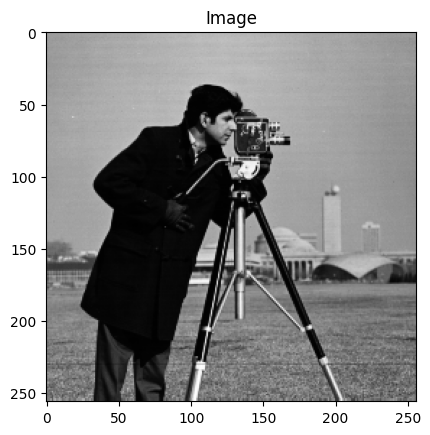

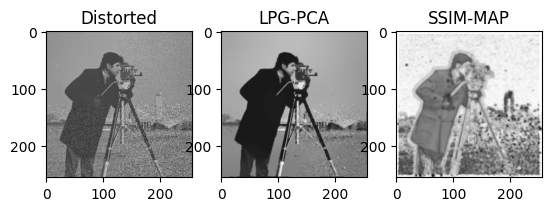

In [27]:
img = Image.open(f'/content/drive/MyDrive/IVP/Set12/01.png')
img = img.convert("L")
aerial = np.asarray(img)
print(aerial.shape)
plt.figure()
plt.imshow(aerial, cmap='gray')
plt.title('Image')

for sigma in [15]:
  plt.figure()
  plt.tight_layout()
  img = Image.open(f'/content/drive/MyDrive/IVP/Set12_noisy/01.png')
  img = img.convert("L")
  aerial2 = np.asarray(img)
  plt.subplot(1,3,1)
  plt.imshow(aerial2, cmap='gray')
  plt.title(f'Distorted')
  newI = lpg_pca(aerial2, sigma, 41, 3, 4, 5)
  ssim_map, ssim = SSIM(aerial, newI)
  plt.subplot(1,3,2)
  plt.imshow(newI, cmap='gray')
  plt.title(f'LPG-PCA')
  plt.subplot(1,3,3)
  plt.imshow(ssim_map, cmap='gray')
  plt.title(f'SSIM-MAP')
  print(f'SSIM = {ssim}')